# **Get Data**

In [ ]:
zip_file = '/content/drive/MyDrive/License_plate_detection/zip_data.zip'

In [ ]:
!unzip -q '/content/drive/MyDrive/License_plate_detection/zip_data.zip'

replace annotations/Cars0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

In [ ]:
# Paths to Images and labels
image_paths = '/content/images'

# Labelling using Canny Edge

In [ ]:
def show_plate(filename):
  img = cv2.imread(filename)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.bilateralFilter(gray, 11,90, 90)
  edges = cv2.Canny(blur, 30, 200)
  cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]
  image_copy = img.copy()
  cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)
  plate = None
  for c in cnts:
      perimeter = cv2.arcLength(c, True)
      edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
      if len(edges_count) == 4:
          x,y,w,h = cv2.boundingRect(c)
          plate = img[y:y+h, x:x+w]
          break
  plt.subplot(1,2,1)
  plt.imshow(image_copy,cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(plate)
  plt.show()

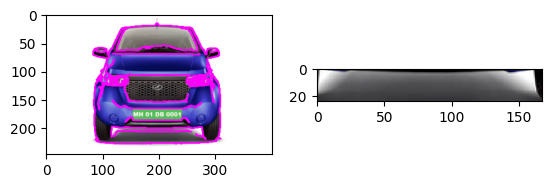

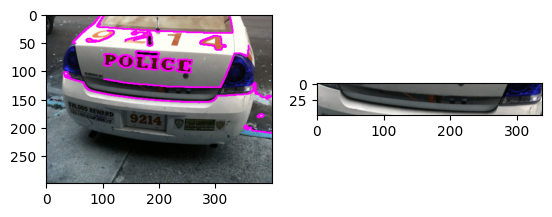

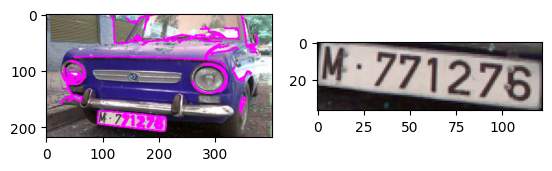

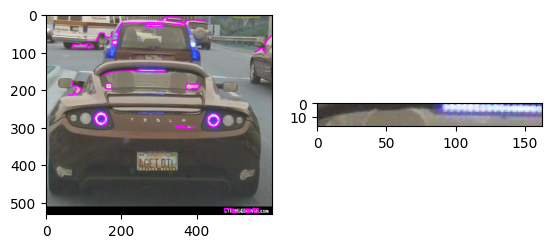

In [ ]:
for file in os.listdir(image_paths)[:4]:
  show_plate(os.path.join(image_paths,file))
  

# Labels


## Labels

In [ ]:
def xml_to_labels():
  df_dict = {
      "filename":[], "xmin":[], "ymin":[],   
      "xmax":[],"ymax":[], "name":[],    
      "width":[], "height":[],
  }
  ANNOTATIONS_PATH = '/content/annotations'
  # Создаем цикл по всем аннотациям из 
  for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
      # Читаем XML-файл с аннотацией
      tree = ET.parse(annotation)
      # Находим тег, соответствующий имени файла
      filename = tree.find('filename').text
      # Создаем цикл по всем элементам XML-файла
      for elem in tree.iter():
          # Достаем из аннотации информацию о размере изображения - ширину и высоту
          if 'size' in elem.tag:
              for attr in list(elem):
                  if 'width' in attr.tag: 
                      width = int(round(float(attr.text)))
                  if 'height' in attr.tag:
                      height = int(round(float(attr.text)))    
          # Достаем информацию о картинке - имя класса и информацию о координатах bounding box 
          if 'object' in elem.tag:
              for attr in list(elem):
                  if 'name' in attr.tag:
                      name = attr.text                 
                      df_dict['name'] += [name]
                      df_dict['width'] += [width]
                      df_dict['height'] += [height] 
                      df_dict['filename'] += [filename]
                              
                  if 'bndbox' in attr.tag:
                      for dim in list(attr):
                          if 'xmin' in dim.tag:
                              xmin = int(round(float(dim.text)))
                              df_dict['xmin'] += [xmin]
                          if 'ymin' in dim.tag:
                              ymin = int(round(float(dim.text)))
                              df_dict['ymin'] += [ymin]                                
                          if 'xmax' in dim.tag:
                              xmax = int(round(float(dim.text)))
                              df_dict['xmax'] += [xmax]                                
                          if 'ymax' in dim.tag:
                              ymax = int(round(float(dim.text)))
                              df_dict['ymax'] += [ymax]   
  return pd.DataFrame(df_dict)                     

In [ ]:
df = xml_to_labels()
df.head()

,filename,xmin,ymin,xmax,ymax,name,width,height
0,Cars11.png,131,206,273,234,licence,400,305
1,Cars428.png,142,128,258,157,licence,400,225
2,Cars95.png,278,182,407,263,licence,600,400
3,Cars250.png,132,123,261,160,licence,400,248
4,Cars50.png,116,55,525,262,licence,590,350


## **Data Visulization**

In [ ]:
def plot_bounding_box(image_folder, image_filename, df=df):

    image_path = os.path.join(image_folder, image_filename)

    img = plt.imread(image_path)

    fig, ax = plt.subplots(figsize=(10, 8))

    ax.imshow(img);

    image_idx = df[df['filename'] == image_filename].index


    x_min = df.loc[image_idx, 'xmin'].values
    y_min = df.loc[image_idx, 'ymin'].values

    box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
    box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values

    for i in range(len(image_idx)):

        rect = patches.Rectangle(
            (x_min[i], y_min[i]),
            box_width[i], 
            box_height[i], 
            linewidth=3, 
            edgecolor='r',
            facecolor='none' 
        )
  
        ax.add_patch(rect);

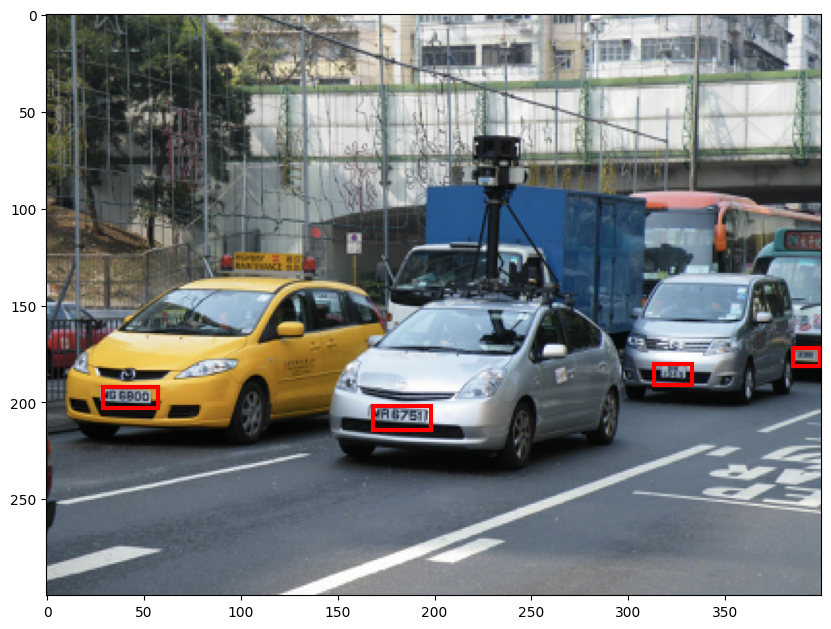

In [ ]:
IMAGES_PATH = '/content/images'
plot_bounding_box(image_folder=IMAGES_PATH, image_filename='Cars330.png', df=df)

# Prepare Data for Yolo

In [ ]:
df.head()

,filename,xmin,ymin,xmax,ymax,name,width,height
0,Cars11.png,131,206,273,234,licence,400,305
1,Cars428.png,142,128,258,157,licence,400,225
2,Cars95.png,278,182,407,263,licence,600,400
3,Cars250.png,132,123,261,160,licence,400,248
4,Cars50.png,116,55,525,262,licence,590,350


In [ ]:
df['center_x'] = (df['xmax']+df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax']+df['ymin'])/(2*df['height'])
df['bb_width'] = (df['xmax']-df['xmin'])/df['width']
df['bb_height'] = (df['ymax']-df['ymin'])/df['height']
df.head()

,filename,xmin,ymin,xmax,ymax,name,width,height,center_x,center_y,bb_width,bb_height
0,Cars11.png,131,206,273,234,licence,400,305,0.505000,0.721311,0.35500,0.091803
1,Cars428.png,142,128,258,157,licence,400,225,0.500000,0.633333,0.29000,0.128889
2,Cars95.png,278,182,407,263,licence,600,400,0.570833,0.556250,0.21500,0.202500
3,Cars250.png,132,123,261,160,licence,400,248,0.491250,0.570565,0.32250,0.149194
4,Cars50.png,116,55,525,262,licence,590,350,0.543220,0.452857,0.69322,0.591429


# Make folder if not exist

In [ ]:
paths = ['data_images','data_images/train','data_images/test']
for path in paths:
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
df['filename'] = '/content/images/'+df['filename']

In [ ]:
# test train split
print('Total data :',df.shape[0])
df_train = df.iloc[:200]
df_test = df.iloc[200:]
print(f'Train data :{df_train.shape[0]} \nTest data :{df_test.shape[0]}')

Total data : 471
Train data :200 
Test data :271


**TEXT FILE:**
class_id,center_x,center_y,bb_width,bb_height

In [ ]:
from shutil import copy
train_folder = '/content/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values

for fname,x,y,w,h in values:
  image_name = os.path.split(fname)[-1]
  txt_name = os.path.splitext(image_name)[0]
  dst_image_path = os.path.join(train_folder, image_name)
  dst_label_file = os.path.join(train_folder, txt_name+'.txt')
  # copy image to folder
  copy(fname,dst_image_path)

  # generate txt which has label info
  label_txt = f'0 {x} {y} {w} {h}'

  with open(dst_label_file,mode='w') as f:
    f.write(label_txt)
    f.close()

In [ ]:
# for test folder
test_folder = '/content/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values

for fname,x,y,w,h in values:
  image_name = os.path.split(fname)[-1]
  txt_name = os.path.splitext(image_name)[0]
  dst_image_path = os.path.join(test_folder, image_name)
  dst_label_file = os.path.join(test_folder, txt_name+'.txt')
  # copy image to folder
  copy(fname,dst_image_path)

  # generate txt which has label info
  label_txt = f'0 {x} {y} {w} {h}'

  with open(dst_label_file,mode='w') as f:
    f.write(label_txt)
    f.close()

In [ ]:
# !cp -r /content/data_images /content/drive/MyDrive/License_plate_detection/yolov5